<a href="https://colab.research.google.com/github/tkdlqh2/Match_sum/blob/main/MatchSum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 설정 + 필요한 모델 다운로드

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 8.6 MB/s 
     |████████████████████████████████| 448 kB 70.7 MB/s 


In [2]:
!pip install git+https://github.com/SKT-AI/KoBART #egg=kobart

  Cloning https://github.com/SKT-AI/KoBART to /tmp/pip-req-build-qqveoye1
  Running command git clone -q https://github.com/SKT-AI/KoBART /tmp/pip-req-build-qqveoye1
     |████████████████████████████████| 132 kB 7.3 MB/s 
     |████████████████████████████████| 814 kB 56.5 MB/s 
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 1.9 MB 40.1 MB/s 
     |████████████████████████████████| 596 kB 70.4 MB/s 
     |████████████████████████████████| 829 kB 63.8 MB/s 
     |████████████████████████████████| 136 kB 87.1 MB/s 
     |████████████████████████████████| 3.3 MB 79.2 MB/s 
     |████████████████████████████████| 895 kB 72.6 MB/s 
     |████████████████████████████████| 1.1 MB 60.4 MB/s 
     |████████████████████████████████| 271 kB 85.2 MB/s 
     |████████████████████████████████| 144 kB 69.6 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
     |████████████████████████████████| 8.7 MB 51.8 MB/s 
     |███████████████████

In [3]:
!pip install transformers

In [4]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 8.9 MB/s 
     |████████████████████████████████| 144 kB 88.8 MB/s 
     |████████████████████████████████| 181 kB 67.1 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b29e8d1f123e42ce21f87d59458f34e3a697309f542502e9ca0f30213ae9a6a2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [5]:
import torch
import os 
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import json
import wandb

from google.colab import drive
import re
from konlpy.tag import Okt
import requests
from bs4 import BeautifulSoup

from itertools import combinations
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader,random_split

from kobart import get_pytorch_kobart_model, get_kobart_tokenizer
from transformers import AutoModel, AutoTokenizer, BartModel

In [6]:
# seed
seed = 7777
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB
cuda


### 원본 데이터 불러오기

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/Summary_task/Training/train_original.json") as f:
  json_data = json.load(f)

In [ ]:
documents = json_data["documents"]

In [ ]:
df = pd.DataFrame(columns=['TITLE','ABS_SUM','CONTENT'])

for document in tqdm(documents[:20000]):
    stc_list = []
    
    for j in document['text'][2:]:
        if j == [] : continue
        stc_list.append(j[0]["sentence"])
            
    df = df.append(pd.DataFrame([[document['title'],document['abstractive'][0],stc_list]], columns=['TITLE','ABS_SUM','CONTENT']), ignore_index=True)

100%|██████████| 20000/20000 [00:32<00:00, 614.52it/s]


In [ ]:
df.head(5)

,TITLE,ABS_SUM,CONTENT
0,"논 타작물 재배, 2월 말까지 신청하세요",전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...,[전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 시행하는 쌀 생산조정제...
1,"여수시, 컬러빌리지 마무리...‘색채와 빛’도시 완성",여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...,[여수시는 원도심 일대에서 추진된 컬러빌리지 사업을 지난해 말 마무리하며 색채와 빛...
2,“새해 정기 받고 올해는 반드시 일내자!”,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...,[전남드래곤즈(사장 신승재)는 지난 4일 구봉산 해맞이 행사를 통해 새해 각오를 다...
3,"농업인 역량 강화, 새해 실용교육 실시","광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 등 지역특화작...",[광양시는 오는 11일부터 24일까지 농업인교육관과 읍면동 회의실에서 농업인 105...
4,타이완 크루즈관광객 4천여명‘전남’온다,올해 4월과 6월 두 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항...,"[타이완의 크루즈관광객 4000여명이 올해 두 차례에 걸쳐 여수에 입항한다., 전라..."


In [ ]:
df.loc[611]

TITLE                              경기불황 불구, 광양지역 기부액 오히려 늘었다
ABS_SUM    지난해 전국적인 경기불황으로 곳곳에서 기부금이 줄어들고 있음에도 불구하고 광양지역은...
CONTENT                                                   []
Name: 611, dtype: object

### 전처리


- 띄어쓰기 및 불용어 처리

In [ ]:
# 한국어 불용어 리스트 크롤링


url = "https://www.ranks.nl/stopwords/korean"
response = requests.get(url, verify = False)

if response.status_code == 200:
    soup = BeautifulSoup(response.text,'html.parser')
    content = soup.select_one('#article178ebefbfb1b165454ec9f168f545239 > div.panel-body > table > tbody > tr')
    stop_words=[]
    for x in content.strings:
        x=x.strip()
        if x:
            stop_words.append(x)
    print(f"# Korean stop words: {len(stop_words)}")
else:
    print(response.status_code)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ranks.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


# Korean stop words: 677


In [ ]:
okt = Okt()

def title_tokenizing(x):
    temp_data = okt.morphs(x)
    temp_list = []
    for word in temp_data:
        if word in stop_words: 
            continue
        temp_list.append(word)
  
    return " ".join(temp_list)
    
    
def content_tokenizing(x):
    new_list = list(filter(None, x))
    
    final_list = []
    for i in new_list:
        temp_data = okt.morphs(i)
        temp_list = []
        for word in temp_data:
            if word in stop_words:
                continue
            temp_list.append(word)
        final_list.append(" ".join(temp_list))

    return final_list

In [ ]:
df_tokenized = pd.DataFrame()
df_tokenized['TITLE'] = df['TITLE'].progress_apply(lambda x: title_tokenizing(x))
df_tokenized['ABS_SUM'] = df['ABS_SUM'].progress_apply(lambda x: title_tokenizing(x))
df_tokenized['CONTENT'] = df['CONTENT'].progress_apply(lambda x: content_tokenizing(x))

100%|██████████| 20000/20000 [1:12:33<00:00,  4.59it/s]


In [ ]:
idx_list = []
for i in range(len(df_tokenized)):
    sentence_list = df_tokenized['CONTENT'].iloc[i]
    if len(sentence_list) == 0:
        idx_list.append(i)

In [ ]:
df_tokenized = df_tokenized.drop(idx_list)

In [ ]:
for i in range(len(df_tokenized)):
    sentence_list = df_tokenized['CONTENT'].iloc[i]
    if len(sentence_list) == 0:
        print(i)

#Extractive summarization - Matchsum

### Dataset & Dataloader 생성

In [ ]:
# input_id 가 들어오면 문장 앞뒤로 cls,sep토큰을 붙여주고 길이에 맞춰 padding을 해준다.
# 문장을 여러 개 합친 조합을 하나의 문장으로 처리해야 하기에 따로 함수가 필요하다

def control_input_ids(input_ids_tensor,length,cls_token_num,sep_token_num,pad_token_num): 
  cur_length = len(input_ids_tensor)
  cls_token = torch.tensor([cls_token_num])
  sep_token = torch.tensor([sep_token_num])

  if cur_length+2 > length:
    input_ids_tensor = input_ids_tensor[:length-2]  # 길이가 넘치면 자른다
    return torch.cat([cls_token,input_ids_tensor,sep_token])
  else:
    input_ids_tensor = torch.cat([cls_token,input_ids_tensor,sep_token])
    padding_list = torch.tensor([pad_token_num]*(length - cur_length -2)) # 길이가 모자라면 padding token 을 채운다
    return torch.cat([input_ids_tensor,padding_list])

In [ ]:
def custom_collate_fn(samples):
  
  text_ids = torch.empty(0,512)
  labels_ids = torch.empty(0,32)
  for sample in samples:
    text_ids = torch.cat([text_ids,sample['text_input_ids'].unsqueeze(0)],dim=0) 
    labels_ids = torch.cat([labels_ids,sample['labels_input_ids'].unsqueeze(0)],dim=0)

  sentence_input_ids = [sample['sentence_input_ids'] for sample in samples]
  nn.utils.rnn.pad_sequence(sentence_input_ids,batch_first=True,padding_value = 3)

  return dict(text_input_ids = text_ids.to(torch.int64), labels_input_ids = labels_ids.to(torch.int64), sentence_input_ids = sentence_input_ids)

In [ ]:
class CustomDataset(Dataset):
  def __init__(
      self, data, tokenizer,
      text_max_token_len = 512,
      summary_max_token_len = 32
        ):
    self.tokenizer = tokenizer
    self.data = data
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    cls_token_num = 0
    sep_token_num = 1
    pad_token_num = 3
    
    data_row = self.data.iloc[index]
    text = data_row['CONTENT']
    
    total_text_ids = torch.tensor([])
    sentence_input_ids = torch.empty(0,32)

    for sentence in text:
      text_encoding_sentence = self.tokenizer(
          sentence,return_tensors = "pt",add_special_tokens=False)
      sentence_indiv_input_ids = text_encoding_sentence['input_ids'].flatten()
      total_text_ids = torch.cat([total_text_ids,sentence_indiv_input_ids])

      sentence_indiv_input_ids = control_input_ids(sentence_indiv_input_ids,self.summary_max_token_len,cls_token_num,sep_token_num,pad_token_num)
      sentence_indiv_input_ids = sentence_indiv_input_ids.unsqueeze(0)
      sentence_input_ids = torch.cat([sentence_input_ids,sentence_indiv_input_ids],dim=0)
    
    sentence_input_ids = sentence_input_ids.to(torch.int64)
    total_text_ids = control_input_ids(total_text_ids,self.text_max_token_len,cls_token_num,sep_token_num,pad_token_num)    
    total_text_ids = total_text_ids

    labels = data_row['TITLE']
    summary_encoding = self.tokenizer(
        labels,
        add_special_tokens = False,
        return_tensors = "pt"
    )

    labels_ids = summary_encoding['input_ids'].flatten()
    labels_ids = control_input_ids(labels_ids,self.summary_max_token_len,cls_token_num,sep_token_num,pad_token_num)

    return dict(text_input_ids = total_text_ids, labels_input_ids = labels_ids, sentence_input_ids = sentence_input_ids)

In [ ]:
tokenizer = get_kobart_tokenizer()

/content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip[██████████████████████████████████████████████████]


In [ ]:
print(tokenizer.decode(torch.tensor([0])))
print(tokenizer.decode(torch.tensor([1])))
print(tokenizer.decode(torch.tensor([3])))

<s>
</s>
<pad>


In [ ]:
whole_dataset = CustomDataset(df_tokenized,tokenizer)

train_set_num = len(df_tokenized)*9//10
train_dataset , valid_dataset = random_split(whole_dataset, [train_set_num,len(df_tokenized)-train_set_num])
train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle=True,collate_fn = custom_collate_fn)
valid_dataloader =  DataLoader(valid_dataset, batch_size = 2, shuffle=False,collate_fn = custom_collate_fn)

In [ ]:
next(iter(train_dataloader))

{'labels_input_ids': tensor([[    0, 24382, 19867, 15004, 14174, 11471, 11372, 10518, 16016, 14871,
          26299, 14468,     1,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3],
         [    0, 14188, 14138, 14138, 13676, 14623, 27917, 15004, 14802, 14092,
           9879, 18374, 14160,  8996, 18374, 14160, 18374, 14031, 13586, 15579,
          18093,     1,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3]]),
 'sentence_input_ids': [tensor([[    0, 14468, 14806, 14770, 14174, 11471, 19696, 29326, 14779, 15785,
           14871,  1700, 10256, 14777, 16260,  1700, 10256, 15665, 14174, 11471,
           14899, 15404, 15082, 17301, 14432, 14068, 19087, 15183, 14871, 14387,
            9067,     1],
          [    0, 14119, 11207, 16297, 14099,  9807, 11372, 20318, 14338, 16309,
           18102, 14702, 14145, 18043, 18102, 14541, 11319, 22554, 15494, 14

### Matchsum

- 평가 metric -> rdass
- 기본적으로 모델에 스코어가 높은 5개의 단일 문장을 뽑고 뽑인 문장으로 만들어진 조합 가운데서 스코어가 높은 조합을 golden summary로 선정
- loss 는 margin ranking loss 사용

In [ ]:
def get_score(doc,label,answer):
  score_1 = torch.cosine_similarity(doc,answer,dim=0)
  score_2 = torch.cosine_similarity(label,answer,dim=0)
  return (score_1+score_2)/2

In [ ]:
def get_candidate_id(doc_emb,summary_emb,batch_sentence_id, candidate_num, extract_model,device):
    cls_token = torch.tensor([0]).to(device)
    sep_token = torch.tensor([1]).to(device)
    candidate_ids = torch.empty([0,candidate_num,128]).to(device)
    
    for batch_idx, sentence_id_tensor in enumerate(batch_sentence_id):
      sentence_id_tensor = sentence_id_tensor.to(device)
      out = extract_model.forward(sentence_id_tensor)  #sentence_id_tensor = [문장 갯수,32개의 토큰]
      hidden_states = out['last_hidden_state'][:,0,:] # [문장 갯수,token 갯수 ,768 dim_vec]
      score_list= []
      
      # 각 문장과 정답 라벨의 score를 비교하여 상위 5개의 문장을 선별한다.(방법은 training encoder 모델을 활용한 rdass)  
      for i in range(hidden_states.shape[0]): 
        score = get_score(doc = doc_emb[batch_idx,:], label = summary_emb[batch_idx,:], answer = hidden_states[i,:])
        score_list.append((score,i))
      
      score_list.sort(key = lambda x: x[0],reverse=True)
      idx_list = [idx for _,idx in score_list][:5]
    
      # 선정된 5개의 문장들로 조합을 한다.
      # 뽑힌 조합 문장을 연결하고 하나의 문장으로 만들어 다시 score를 측정한다.
      # 문서의 문장이 적어 candidate_num보다 조합갯수가 적을 경우 조합을 반복하여 갯수를 맞춘다.
      indices = list(combinations(idx_list, 2))
      indices += list(combinations(idx_list, 3))
      
      if len(indices) < 2:
        indices = [idx_list]
      
      len_indices = len(indices) 
      if len_indices < candidate_num : 
        indices = indices*(candidate_num//len_indices)
        indices.append(idx_list[:-(candidate_num%len_indices)])

      # 각 조합 문장과 score를 tuple로 묶고 score 기준으로 내림차순한다.
      score = []
      for i in indices:
          i = list(i)
          i.sort()
          # write dec
          dec = torch.tensor([]).to(device)
          for j in i:
              sent = sentence_id_tensor[j]
              sent = sent[1:]
              sep_token_idx = 0
              for token_idx in range(len(sent)):
                if sent[token_idx] == 2: break
                else:sep_token_idx += 1
              sent = sent[:sep_token_idx]
              dec = torch.cat([dec,sent],dim=0)
          
          dec = torch.cat([cls_token,dec,sep_token],dim=0)
          dec = dec.to(torch.int64)
          dec_out = extract_model.forward(input_ids = dec.unsqueeze(0))
          score.append((dec, get_score(doc_emb[batch_idx,:],summary_emb[batch_idx,:], dec_out['last_hidden_state'][0,0,:])))
      
      score.sort(key=lambda x : x[1], reverse=True)
      score = score[:candidate_num]
      
      candidate_ids_ind= torch.empty(0,128).to(device)
      for k,_ in score:
        dec = k
        if len(dec) < 128:
          padding_list = torch.tensor([3]*(128-len(dec))).to(device)
          dec = torch.cat([k,padding_list],dim=0)
        else:
          dec = dec[:128]

        candidate_ids_ind = torch.cat([candidate_ids_ind,dec.unsqueeze(0)],dim = 0)

      candidate_ids = torch.cat([candidate_ids,candidate_ids_ind.unsqueeze(0)],dim = 0)

    return candidate_ids.to(torch.int64)

In [ ]:
class MatchSum(nn.Module):  
    def __init__ (self, encoder, candidate_num, device,hidden_size=768):
        super(MatchSum, self).__init__()
        
        self.hidden_size = hidden_size
        self.candidate_num  = candidate_num
        self.encoder = encoder
        self.device = device

    def forward(self, text_id, summary_id,list_of_sentence_id):
        
        batch_size = text_id.size(0)
        pad_id = 3

        # get document embedding
        input_mask = ~(text_id == pad_id)
        out = self.encoder(text_id, attention_mask=input_mask)['last_hidden_state'] # last layer
        doc_emb = out[:, 0, :]
        assert doc_emb.size() == (batch_size, self.hidden_size) # [batch_size, hidden_size]
        
        # get summary embedding
        input_mask = ~(summary_id == pad_id)
        out = self.encoder(summary_id, attention_mask=input_mask)['last_hidden_state'] # last layer
        summary_emb = out[:, 0, :]
        assert summary_emb.size() == (batch_size, self.hidden_size) # [batch_size, hidden_size]

        # get summary score
        summary_score = torch.cosine_similarity(summary_emb, doc_emb, dim=-1)

        # get candidate embedding
        candidate_id = get_candidate_id(doc_emb,summary_emb,list_of_sentence_id, self.candidate_num, self.encoder,self.device) #[batch_size , candidate_num, token_num]
        candidate_id_copy = candidate_id
        candidate_id = candidate_id.view(-1, candidate_id.size(-1)) 
        input_mask = ~(candidate_id == pad_id)
        out = self.encoder(candidate_id, attention_mask=input_mask)['last_hidden_state'] 
        candidate_emb = out[:, 0, :].view(batch_size, self.candidate_num, self.hidden_size)  # [batch_size, candidate_num, hidden_size]
        assert candidate_emb.size() == (batch_size, self.candidate_num, self.hidden_size)
        
        # get candidate score
        doc_emb = doc_emb.unsqueeze(1).expand_as(candidate_emb)
        score = torch.cosine_similarity(candidate_emb, doc_emb, dim=-1) # [batch_size, candidate_num]
        golden_list = torch.argmax(score,dim=1)
        assert score.size() == (batch_size, self.candidate_num)

        candidate_id = candidate_id.view(-1, candidate_id.size(-1)) 

        return {'score': score, 'summary_score': summary_score,  'golden_summary':candidate_id_copy[:,0,:]}

In [ ]:
class MarginRankingLoss():      
    
    def __init__(self, margin, score=None, summary_score=None):
        super(MarginRankingLoss, self).__init__()
        # self._init_param_map(score=score, summary_score=summary_score)
        self.margin = margin
        self.loss_func = torch.nn.MarginRankingLoss(margin)

    def get_loss(self, score, summary_score):
        
        # equivalent to initializing TotalLoss to 0
        # here is to avoid that some special samples will not go into the following for loop
        ones = torch.ones(score.size()).cuda(score.device)
        loss_func = torch.nn.MarginRankingLoss(0.0)
        TotalLoss = loss_func(score, score, ones)

        # candidate loss
        n = score.size(1)
        for i in range(1, n):
            pos_score = score[:, :-i]
            neg_score = score[:, i:]
            pos_score = pos_score.contiguous().view(-1)
            neg_score = neg_score.contiguous().view(-1)
            ones = torch.ones(pos_score.size()).cuda(score.device)
            loss_func = torch.nn.MarginRankingLoss(self.margin * i)
            TotalLoss += loss_func(pos_score, neg_score, ones)

        # gold summary loss
        pos_score = summary_score.unsqueeze(-1).expand_as(score)
        neg_score = score
        pos_score = pos_score.contiguous().view(-1)
        neg_score = neg_score.contiguous().view(-1)
        ones = torch.ones(pos_score.size()).cuda(score.device)
        loss_func = torch.nn.MarginRankingLoss(0.0)
        TotalLoss += loss_func(pos_score, neg_score, ones)
        
        return TotalLoss

### Train code

- Encoder -> KoBART
- GLM 을 제외한 제일 성능 좋은 모델이고 한국어로 train이 되어 있어 선정함

In [ ]:
model = BartModel.from_pretrained(get_pytorch_kobart_model())
summary_model = MatchSum(encoder = model, candidate_num = 5,device = device, hidden_size=768) 

N_EPOCHS = 3
optimizer = AdamW(model.parameters(),lr =5e-5)
scheduler = CosineAnnealingLR(optimizer,T_max = len(train_dataloader)*2)
criterion = MarginRankingLoss(margin = 0.01)

/content/.cache/kobart_base_cased_ff4bda5738.zip[██████████████████████████████████████████████████]


In [ ]:
model.to(device)
summary_model.to(device)
wandb.init(project='summarization', entity='tkdlqh2')

for epoch in range(N_EPOCHS):
    
    print(f"*****Epoch {epoch} Train Start*****")
    print(f"*****Epoch {epoch} Total Step {len(train_dataloader)}*****")
    total_loss, batch_loss, batch_step = 0,0,0
    model.train()

    for step, batch in enumerate(train_dataloader):
        batch_step+=1
        text_input_ids = batch["text_input_ids"].to(device)        
        label_input_ids = batch["labels_input_ids"].to(device)

        model.zero_grad()
        optimizer.zero_grad()

        # forward
        output = summary_model.forward(text_input_ids, label_input_ids,batch["sentence_input_ids"])
        loss = criterion.get_loss(score = output["score"],summary_score = output["summary_score"])

        # loss 계산
        loss.backward()
        # optimizer 업데이트
        optimizer.step()
        # scheduler 업데이트
        scheduler.step()

        batch_loss += loss.item()
        total_loss += loss.item()

        learning_rate = optimizer.param_groups[0]['lr']
        wandb.log({'train/lr':learning_rate,"train/loss":loss.item()})

        if (step%50 == 0) and (step!=0):
            print(f"Step: {step} Loss: {batch_loss/batch_step:.4f} lr: {optimizer.param_groups[0]['lr']:.4f}")
            # 변수 초기화    
            batch_loss, batch_step = 0,0

    print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
    
    with torch.no_grad():
      print('**Calculating validation results...**')
      total_val_loss,batch_step = 0,0
      model.eval()
      for step, batch in enumerate(valid_dataloader):
          batch_step+=1
          text_input_ids = batch["text_input_ids"].to(device)        
          label_input_ids = batch["labels_input_ids"].to(device)

          # forward
          output = summary_model.forward(text_input_ids, label_input_ids,batch["sentence_input_ids"])
          val_loss = criterion.get_loss(score = output["score"],summary_score = output["summary_score"])

          total_val_loss += val_loss.item()
          wandb.log({"val/loss":val_loss.item()})

    print(f"Epoch {epoch} Total Mean Score : {total_val_loss/(step+1):.4f}")
    
    print(f"*****Epoch {epoch} Train Finished*****\n")
    torch.save(model.state_dict(),f"/content/drive/MyDrive/Summary_task/kobart_model_{epoch}epoch.pth")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


*****Epoch 0 Train Start*****
*****Epoch 0 Total Step 8990*****
Step: 50 Loss: 0.1260 lr: 0.0000
Step: 100 Loss: 0.0917 lr: 0.0000
Step: 150 Loss: 0.0936 lr: 0.0000
Step: 200 Loss: 0.0821 lr: 0.0000
Step: 250 Loss: 0.0772 lr: 0.0000
Step: 300 Loss: 0.0848 lr: 0.0000
Step: 350 Loss: 0.0662 lr: 0.0000
Step: 400 Loss: 0.0841 lr: 0.0000
Step: 450 Loss: 0.0764 lr: 0.0000
Step: 500 Loss: 0.0517 lr: 0.0000
Step: 550 Loss: 0.0749 lr: 0.0000
Step: 600 Loss: 0.0640 lr: 0.0000
Step: 650 Loss: 0.0532 lr: 0.0000
Step: 700 Loss: 0.0635 lr: 0.0000
Step: 750 Loss: 0.0652 lr: 0.0000
Step: 800 Loss: 0.0490 lr: 0.0000
Step: 850 Loss: 0.0448 lr: 0.0000
Step: 900 Loss: 0.0456 lr: 0.0000
Step: 950 Loss: 0.0481 lr: 0.0000
Step: 1000 Loss: 0.0544 lr: 0.0000
Step: 1050 Loss: 0.0611 lr: 0.0000
Step: 1100 Loss: 0.0436 lr: 0.0000
Step: 1150 Loss: 0.0434 lr: 0.0000
Step: 1200 Loss: 0.0482 lr: 0.0000
Step: 1250 Loss: 0.0397 lr: 0.0000
Step: 1300 Loss: 0.0465 lr: 0.0000
Step: 1350 Loss: 0.0488 lr: 0.0000
Step: 1400 

In [ ]:
print(text_input_ids)

tensor([[    0, 14504, 14047,  ...,     3,     3,     3],
        [    0, 21004,  9103,  ...,     3,     3,     3]], device='cuda:0')


In [ ]:
print(batch["sentence_input_ids"])

[tensor([[    0, 14504, 14047, 12080, 14087, 13328, 15494, 17932, 14047, 11821,
         14378, 12060, 14497, 18374, 14596, 18374, 14032, 17923, 22581, 14899,
         14255, 14032, 14821, 15550, 14087, 12943, 14895, 17612, 14121, 22214,
         14533,     1],
        [    0, 17134, 14504, 14047, 12080, 14087, 13328, 14415, 11280, 24539,
         16201, 15686, 14558, 15482,  8981, 29465, 28228, 14806, 14938, 11776,
         15989, 15286, 14207, 14455, 15240, 15665, 15743, 24227, 19025, 11280,
         14025,     1]]), tensor([[    0, 21004,  9103, 14143, 14031,  9092, 23999, 15494, 14733, 18784,
         14031,  9092, 12130, 15236, 16959, 15221, 14036, 14479, 13173,  9545,
         17819, 23469, 20683, 16395, 14025,  9754, 17546,     1,     3,     3,
             3,     3],
        [    0, 14438, 11806, 14806, 27026, 14623, 15053, 15487, 17289, 19539,
         17960, 17486, 14158, 12141, 14641, 18294, 15880, 12123, 20008, 26497,
         19787, 21283, 16390, 15004, 16304, 14894, 11465

### Model-Load & Inference

In [7]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/Summary_task/Validation/valid_original.json") as f:
  json_data_val = json.load(f)

In [ ]:
documents = json_data_val["documents"]
df_val = pd.DataFrame(columns=['TITLE','ABS_SUM','CONTENT'])

for document in tqdm(documents[:20000]):
    stc_list = []
    
    for j in document['text'][2:]:
        if j == [] : continue
        stc_list.append(j[0]["sentence"])
            
    df_val = df_val.append(pd.DataFrame([[document['title'],document['abstractive'][0],stc_list]], columns=['TITLE','ABS_SUM','CONTENT']), ignore_index=True)

100%|██████████| 20000/20000 [00:27<00:00, 734.94it/s]


In [ ]:
df_val.head()

,TITLE,ABS_SUM,CONTENT
0,"文대통령 ""5G는 4차산업혁명 시대의 고속도로""",8일 서울에서 열린 5G플러스 전략발표에 참석한 문재인 대통령은 5G는 대한민국 혁...,"[문 대통령은 ""5G가 각 분야에 융합되면, 정보통신산업을 넘어 자동차, 드론(무인..."
1,"""손학규 물러나라""...바른계, 최고위 회의 '보이콧'",8일 바른미래당 최고의원 회의에 하태경 의원 등 5명의 최고의원이 지도부 퇴진을 요...,"[손 대표는 회의를 주재하면서 ""의원들이나 지역위원장들, 당원들이 다음 선거에 대해..."
2,"""마치 한 장소처럼"" ... 5G로 서울·부산·광주 원격협연",지난 3일 한국이 세계 첫 5세대 이동통신 서비스를 보편화한 것을 축하하는 '코리안...,"[그러나 이 공연은 5G 이동통신의 실시간 전송기술을 활용해 서울과 부산, 광주에서..."
3,"""이웃도 모르는데, 이게 서울 미래냐""...'고층 재개발 요구' 작심 비판한 박원순",박원순 서울시장은 8일 서울시청에서 열린 '골목길 재생 시민 정책 대화'에 참석하여...,"[박 시장은 ""여러분 제가 피 흘리고 서 있는 게 안 보이시나요. 저를 상대로 얼마..."
4,"""SK·알파벳 벤치마킹해야""...KB운용, KMH에 주주서한",주주가치 포커스를 운용하는 KB자산운용이 SK와 알파벳(구글 지주회사)의 모범적 ...,"[SK와 알파벳은 신규 투자는 지주회사가 전담하고, 자회사는 본업에만 충실할 수 있..."


In [ ]:
# train data 와 같은 전처리를 적용한다.

# 한국어 불용어 리스트 크롤링


url = "https://www.ranks.nl/stopwords/korean"
response = requests.get(url, verify = False)

if response.status_code == 200:
    soup = BeautifulSoup(response.text,'html.parser')
    content = soup.select_one('#article178ebefbfb1b165454ec9f168f545239 > div.panel-body > table > tbody > tr')
    stop_words=[]
    for x in content.strings:
        x=x.strip()
        if x:
            stop_words.append(x)
    print(f"# Korean stop words: {len(stop_words)}")
else:
    print(response.status_code)

okt = Okt()

def title_tokenizing(x):
    temp_data = okt.morphs(x)
    temp_list = []
    for word in temp_data:
        if word in stop_words: 
            continue
        temp_list.append(word)
  
    return " ".join(temp_list)
    
    
def content_tokenizing(x):
    new_list = list(filter(None, x))
    
    final_list = []
    for i in new_list:
        temp_data = okt.morphs(i)
        temp_list = []
        for word in temp_data:
            if word in stop_words:
                continue
            temp_list.append(word)
        final_list.append(" ".join(temp_list))

    return final_list

# input_id 가 들어오면 문장 앞뒤로 cls,sep토큰을 붙여주고 길이에 맞춰 padding을 해준다.
# 문장을 여러 개 합친 조합을 하나의 문장으로 처리해야 하기에 따로 함수가 필요하다

def control_input_ids(input_ids_tensor,length,cls_token_num,sep_token_num,pad_token_num): 
  cur_length = len(input_ids_tensor)
  cls_token = torch.tensor([cls_token_num])
  sep_token = torch.tensor([sep_token_num])

  if cur_length+2 > length:
    input_ids_tensor = input_ids_tensor[:length-2]  # 길이가 넘치면 자른다
    return torch.cat([cls_token,input_ids_tensor,sep_token])
  else:
    input_ids_tensor = torch.cat([cls_token,input_ids_tensor,sep_token])
    padding_list = torch.tensor([pad_token_num]*(length - cur_length -2)) # 길이가 모자라면 padding token 을 채운다
    return torch.cat([input_ids_tensor,padding_list])

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ranks.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


# Korean stop words: 677


In [ ]:
df_tokenized_val = pd.DataFrame()
df_tokenized_val['TITLE'] = df_val['TITLE'].progress_apply(lambda x: title_tokenizing(x))
df_tokenized_val['ABS_SUM'] = df_val['ABS_SUM'].progress_apply(lambda x: title_tokenizing(x))
df_tokenized_val['CONTENT'] = df_val['CONTENT'].progress_apply(lambda x: content_tokenizing(x))

100%|██████████| 20000/20000 [10:34<00:00, 31.51it/s]


In [ ]:
df_tokenized_val.head()

,TITLE,ABS_SUM,CONTENT
0,"文 대통령 "" 5 G 는 4 차 산업혁명 시대 고속도로 """,8일 서울 열린 5 G 플러스 전략 발표 참석 한 문재인 대통령 은 5 G 는 대한...,"[문 대통령 은 "" 5 G 분야 융합 되면 , 정보통 신 산업 넘어 자동차 , 드론..."
1,""" 손학규 물러나라 ""... 바른계 , 최고 위 회의 ' 보이콧 '",8일 바른 미래 당 최고 의원 회의 하태경 의원 5 명의 최고 의원 지 도부 퇴진 ...,"[손 대표 는 회의 주재 "" 의원 이나 지역 위원장 , 당원 선거 대해 불안하게 생..."
2,""" 한 장소 처럼 "" ... 5 G 서울 · 부산 · 광주 원격협연",지난 3일 한국 세계 첫 5 세대 이동통신 서비스 보편화 한 축하 하는 ' 코리안 ...,"[공연 은 5 G 이동통신 실시간 전송 기술 활용 해 서울 부산 , 광주 동시 하는..."
3,""" 이웃 도 모르는데 , 게 서울 미래 냐 ""...' 고층 재개발 요구 ' 작심 비...",박원순 서울시장 은 8일 서 울 시청 열린 ' 골목길 재생 시민 정책 대화 ' 참석...,"[박 시장 은 "" 피 흘리고 서 있는 게 안 보이시나요 . 상대로 많은 사람 층 고..."
4,""" SK · 알파벳 벤치마킹 해야 ""... KB 운용 , KMH 주주 서한",주주 가치 포커스 운용 하는 KB 자산운용 SK 알파벳 ( 구글 지주회사 ) 모범 ...,"[SK 알파벳 은 신규 투자 는 지주회사 전담 하고 , 자회사 는 본업 에만 충실할..."


In [ ]:
idx_list = []
for i in range(len(df_tokenized_val)):
    sentence_list = df_tokenized_val['CONTENT'].iloc[i]
    if len(sentence_list) == 0:
        idx_list.append(i)

df_tokenized_val = df_tokenized_val.drop(idx_list)

In [ ]:
for i in range(len(df_tokenized_val)):
    sentence_list = df_tokenized_val['CONTENT'].iloc[i]
    if len(sentence_list) == 0:
        print(i)

In [ ]:
model = BartModel.from_pretrained(get_pytorch_kobart_model())
model.load_state_dict(state_dict = torch.load("/content/drive/MyDrive/Summary_task/kobart_model_1epoch.pth"))
model.eval()

/content/.cache/kobart_base_cased_ff4bda5738.zip[██████████████████████████████████████████████████]


BartModel(
  (shared): Embedding(30000, 768, padding_idx=3)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(30000, 768, padding_idx=3)
    (embed_positions): BartLearnedPositionalEmbedding(1028, 768, padding_idx=3)
    (layers): ModuleList(
      (0): BartEncoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): BartEncoderLayer(
        (self_attn): BartAttention(
   

In [ ]:
model.to(device)
summary_model = MatchSum(encoder = model, candidate_num = 1,device = device, hidden_size=768) 

In [ ]:
def to_total(x):
  total_str = ""
  for sentence in x:
    total_str += " "
    total_str += sentence
  
  return total_str

class get_ids():
    def __init__(self,tokenizer):
      self.tokenizer = tokenizer

    def __call__(self, sentence):
      ids = self.tokenizer(sentence)['input_ids']
      ids = torch.tensor(ids)
      return control_input_ids(ids,32,0,2,1).unsqueeze(0).to(torch.int64)

class get_list_ids():
    def __init__(self,tokenizer,device):
      self.tokenizer = tokenizer
      self.device = device
    def __call__(self, sentence_list):

      ans = torch.empty((0,32),dtype = torch.int64).to(self.device)
      for sentence in sentence_list:
        ids = self.tokenizer(sentence)['input_ids']
        ids = torch.tensor(ids,dtype = torch.int64)
        ans = torch.cat([ans,control_input_ids(ids,32,0,2,1).unsqueeze(0).to(torch.int64).to(device)],dim=0)
      return [ans]

In [ ]:
tokenizer = get_kobart_tokenizer()

/content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip[██████████████████████████████████████████████████]


In [ ]:
ids_class = get_ids(tokenizer)
ids_list_class = get_list_ids(tokenizer,device)

In [ ]:
df_tokenized_val["text"] = df_tokenized_val["CONTENT"].apply(lambda x: to_total(x))
df_tokenized_val["text_ids"] = df_tokenized_val["text"].apply(lambda x: ids_class(x))
df_tokenized_val["label_ids"] = df_tokenized_val["TITLE"].apply(lambda x: ids_class(x))
df_tokenized_val['list_of_sentence_ids'] = df_tokenized_val["CONTENT"].progress_apply(lambda x: ids_list_class(x))

100%|██████████| 19764/19764 [00:36<00:00, 537.86it/s]


In [ ]:
df_tokenized_val['model_answer'] = df_tokenized_val["CONTENT"]
for i in tqdm(range(len(df_tokenized_val))):
    try:
        output = summary_model.forward(df_tokenized_val["text_ids"].iloc[i].to(device),df_tokenized_val["label_ids"][i].to(device),df_tokenized_val['list_of_sentence_ids'].iloc[i])
        df_tokenized_val['model_answer'].iloc[i] = output['golden_summary'].detach().cpu().numpy()
    except: continue

100%|██████████| 19764/19764 [2:05:06<00:00,  2.63it/s]


In [ ]:
df_tokenized_val.head()

,TITLE,ABS_SUM,CONTENT,text,text_ids,label_ids,list_of_sentence_ids,model_answer
0,"文 대통령 "" 5 G 는 4 차 산업혁명 시대 고속도로 """,8일 서울 열린 5 G 플러스 전략 발표 참석 한 문재인 대통령 은 5 G 는 대한...,"[문 대통령 은 "" 5 G 분야 융합 되면 , 정보통 신 산업 넘어 자동차 , 드론...","문 대통령 은 "" 5 G 분야 융합 되면 , 정보통 신 산업 넘어 자동차 , 드론...","[[tensor(0), tensor(14111), tensor(14305), ten...","[[tensor(0), tensor(1700), tensor(4361), tenso...","[[[tensor(0, device='cuda:0'), tensor(14111, d...","[[0, 14111, 14305, 14806, 14050, 14144, 15464,..."
1,""" 손학규 물러나라 ""... 바른계 , 최고 위 회의 ' 보이콧 '",8일 바른 미래 당 최고 의원 회의 하태경 의원 5 명의 최고 의원 지 도부 퇴진 ...,"[손 대표 는 회의 주재 "" 의원 이나 지역 위원장 , 당원 선거 대해 불안하게 생...","손 대표 는 회의 주재 "" 의원 이나 지역 위원장 , 당원 선거 대해 불안하게 생...","[[tensor(0), tensor(14316), tensor(14328), ten...","[[tensor(0), tensor(14050), tensor(14316), ten...","[[[tensor(0, device='cuda:0'), tensor(14316, d...","[[0, 14316, 14328, 15494, 15915, 21439, 14050,..."
2,""" 한 장소 처럼 "" ... 5 G 서울 · 부산 · 광주 원격협연",지난 3일 한국 세계 첫 5 세대 이동통신 서비스 보편화 한 축하 하는 ' 코리안 ...,"[공연 은 5 G 이동통신 실시간 전송 기술 활용 해 서울 부산 , 광주 동시 하는...","공연 은 5 G 이동통신 실시간 전송 기술 활용 해 서울 부산 , 광주 동시 하는...","[[tensor(0), tensor(15379), tensor(14806), ten...","[[tensor(0), tensor(14050), tensor(14036), ten...","[[[tensor(0, device='cuda:0'), tensor(15379, d...","[[0, 16414, 14305, 15004, 14554, 28492, 14062,..."
3,""" 이웃 도 모르는데 , 게 서울 미래 냐 ""...' 고층 재개발 요구 ' 작심 비...",박원순 서울시장 은 8일 서 울 시청 열린 ' 골목길 재생 시민 정책 대화 ' 참석...,"[박 시장 은 "" 피 흘리고 서 있는 게 안 보이시나요 . 상대로 많은 사람 층 고...","박 시장 은 "" 피 흘리고 서 있는 게 안 보이시나요 . 상대로 많은 사람 층 고...","[[tensor(0), tensor(14169), tensor(14558), ten...","[[tensor(0), tensor(14050), tensor(18049), ten...","[[[tensor(0, device='cuda:0'), tensor(14169, d...","[[0, 14169, 14558, 14806, 14050, 14250, 15910,..."
4,""" SK · 알파벳 벤치마킹 해야 ""... KB 운용 , KMH 주주 서한",주주 가치 포커스 운용 하는 KB 자산운용 SK 알파벳 ( 구글 지주회사 ) 모범 ...,"[SK 알파벳 은 신규 투자 는 지주회사 전담 하고 , 자회사 는 본업 에만 충실할...","SK 알파벳 은 신규 투자 는 지주회사 전담 하고 , 자회사 는 본업 에만 충실할...","[[tensor(0), tensor(15517), tensor(28214), ten...","[[tensor(0), tensor(14050), tensor(15517), ten...","[[[tensor(0, device='cuda:0'), tensor(15517, d...","[[0, 15517, 28214, 10860, 14806, 16173, 14559,..."


In [ ]:
df_tokenized_val['model_answer_sentence'] = df_tokenized_val['model_answer']
for i in range(len(df_tokenized_val)):
    try : df_tokenized_val['model_answer_sentence'].iloc[i] = tokenizer.decode(token_ids = df_tokenized_val['model_answer'].iloc[i][0], skip_special_tokens = True)
    except: df_tokenized_val['model_answer_sentence'].iloc[i] = "error_sentence"


In [ ]:
df_tokenized_val_new = df_tokenized_val[['TITLE','text','model_answer_sentence']]
df_tokenized_val_new.to_csv("/content/drive/MyDrive/temp_df.csv",mode = 'w')

In [ ]:
idx = 27
print(df_tokenized_val_new['TITLE'].iloc[idx])
print(df_tokenized_val_new['text'].iloc[idx])
print(df_tokenized_val_new['model_answer_sentence'].iloc[idx])

박진희 , ' 횡령 피고인 ' 행사 MC → ' 닥터 탐정 ' 하차 요구 시위
 ' SBS 는 공직자 부인 하지 말아야 할 행동 한 박진희 즉각 퇴 출시 켜야 한다 ' 며 ' 사회 고발 드라마 논란 배우 박진희 왠 말 이냐 ' 는 뜻 전 했다 . 박진희 는 지난해 순천 지역 개발 사업 관련 해 횡령 혐의 재판 받고 있는 A 씨 주최 행사 MC 참석 했다 . 의혹 커지자 박진희 소속사 엘리 펀 엔터테인먼트 측은 ' A 씨 일과 박진희 남편 B 판사 는 전혀 연관 되지 않았다 ' 며 ' A 씨 재판 은 4월 시작 됐는데 , 당시 박진희 남편 은 광주 지법 근무 했다 . A 씨 사건 은 형사 재판 박진희 남편 은 민사 담당 이다 ' 고 해명 했다 . 그러면서 ' 문제 있을 만 한 곳 이란 걸 알았으면 당연히 참석 하지 않았을 ' 라며 ' 박진희 는 보통 행사 처럼 MC 보는 정도 생각 하고 갔다 . 사적 인 자리 간 아니다 ' 고 억울함을 전 했다 . 박진희 는 SBS 새 드라마 ' 닥터 탐정 ' 앞두고 .
' SBS 는 공직자 부인 하지 말아야 할 행동 한 박진희 즉각 퇴 출시 켜야 한다'며'사회 고발 드라마 논란 배우 박진희 왠 의혹 커지자 박진희 소속사 엘리 펀 엔터테인먼트 측은'A 씨 일과 박진희 남편 B 판사 는 전혀 연관 되지 않았다'며'A 그러면서'문제 있을 만 한 곳 이란 걸 알았으면 당연히 참석 하지 않았을'라며'박진희 는 보통 행사 처럼 MC 보는 정도 생각 하고


In [ ]:
df_new_for_answer = pd.read_csv("/content/drive/MyDrive/temp_df.csv")

In [ ]:
class rdass:
  def __init__(self,encoder,tokenizer):
    self.encoder = encoder
    self.tokenizer = tokenizer
    self.encoder.eval()
  def __call__(self, text = None, label = None, answer = None):
    with torch.no_grad():
      text_ids = self.tokenizer(text,truncation = True,max_length = 512,return_tensors = 'pt')
      label_ids = self.tokenizer(label,return_tensors = 'pt')
      answer_ids = self.tokenizer(answer,return_tensors = 'pt')
      # print(text_ids['input_ids'].shape," ",label_ids['input_ids'].shape," ",answer_ids['input_ids'].shape)
      vector_text = self.encoder(**text_ids)['last_hidden_state'] # vector_d
      vector_label = self.encoder(**label_ids)['last_hidden_state'] # vector_r
      vector_answer = self.encoder(**answer_ids)['last_hidden_state'] # vector_p
      
    return get_score(vector_text[0,0,:],vector_label[0,0,:],vector_answer[0,0,:])

In [ ]:
tokenzier_for_eval = AutoTokenizer.from_pretrained("klue/roberta-small")
model_for_eval = AutoModel.from_pretrained("klue/roberta-small")
metric = rdass(model_for_eval,tokenzier_for_eval)

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric = rdass(model_for_eval,tokenzier_for_eval)

In [ ]:
print(df_new_for_answer['model_answer_sentence'])

0        문 대통령 은 " 5 G 분야 융합 되면, 정보통 신 산업 넘어 자동차, 드론 ( ...
1        손 대표 는 회의 주재 " 의원 이나 지역 위원장, 당원 선거 대해 불안하게 생각 ...
2        문재인 대통령, 홍 남기 부총리 겸 기획재정부 장관 유영민 과학기술 정보통신부 장관...
3        박 시장 은 " 피 흘리고 서 있는 게 안 보이시나요. 상대로 많은 사람 층 고를 ...
4        SK 알파벳 은 신규 투자 는 지주회사 전담 하고, 자회사 는 본업 에만 충실할 수...
                               ...                        
19759    김영태 KCFT 대표 는 " KCFT 도전 기술 력 만나 초 극 박 세계 최 장 길...
19760    ' 신한 BNPP 글로벌 단기채 권 펀드'는 시장 환경 투자자 니 즈 반영 하여 설...
19761    한편 삼육대 는 개교 113 주년 터전 이전 70 주년 맞아 한 주 다양한 기념 사...
19762    한국 학자 로는 고려대 최호철 BK 21 플러스 한국어 문학사 업단 단장, 승철 교...
19763    서울시 경기도 2020년 모든 마을 버스 공공 와이파이 설치 할 계획 인데, 이보 ...
Name: model_answer_sentence, Length: 19764, dtype: object


In [ ]:
df_new_for_answer['score'] = df_new_for_answer['text']
for i in tqdm(range(len(df_new_for_answer))):
    if df_new_for_answer['model_answer_sentence'].iloc[i] == "error_sentence": continue
    
    else:
        df_new_for_answer['score'].iloc[i] = metric(
                                                text = df_new_for_answer['text'].iloc[i],
                                                label = df_new_for_answer['TITLE'].iloc[i], 
                                                answer = df_new_for_answer['model_answer_sentence'].iloc[i]
    )

  0%|          | 0/19764 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 19764/19764 [1:15:30<00:00,  4.36it/s]


In [ ]:
df_new_for_answer.head(20)

,Unnamed: 0,TITLE,text,model_answer_sentence,score
0,0,"文 대통령 "" 5 G 는 4 차 산업혁명 시대 고속도로 ""","문 대통령 은 "" 5 G 분야 융합 되면 , 정보통 신 산업 넘어 자동차 , 드론...","문 대통령 은 "" 5 G 분야 융합 되면, 정보통 신 산업 넘어 자동차, 드론 ( ...",<built-in method item of Tensor object at 0x7f...
1,1,""" 손학규 물러나라 ""... 바른계 , 최고 위 회의 ' 보이콧 '","손 대표 는 회의 주재 "" 의원 이나 지역 위원장 , 당원 선거 대해 불안하게 생...","손 대표 는 회의 주재 "" 의원 이나 지역 위원장, 당원 선거 대해 불안하게 생각 ...",<built-in method item of Tensor object at 0x7f...
2,2,""" 한 장소 처럼 "" ... 5 G 서울 · 부산 · 광주 원격협연","공연 은 5 G 이동통신 실시간 전송 기술 활용 해 서울 부산 , 광주 동시 하는...","문재인 대통령, 홍 남기 부총리 겸 기획재정부 장관 유영민 과학기술 정보통신부 장관...",<built-in method item of Tensor object at 0x7f...
3,3,""" 이웃 도 모르는데 , 게 서울 미래 냐 ""...' 고층 재개발 요구 ' 작심 비...","박 시장 은 "" 피 흘리고 서 있는 게 안 보이시나요 . 상대로 많은 사람 층 고...","박 시장 은 "" 피 흘리고 서 있는 게 안 보이시나요. 상대로 많은 사람 층 고를 ...",<built-in method item of Tensor object at 0x7f...
4,4,""" SK · 알파벳 벤치마킹 해야 ""... KB 운용 , KMH 주주 서한","SK 알파벳 은 신규 투자 는 지주회사 전담 하고 , 자회사 는 본업 에만 충실할...","SK 알파벳 은 신규 투자 는 지주회사 전담 하고, 자회사 는 본업 에만 충실할 수...",<built-in method item of Tensor object at 0x7f...
5,5,"' 페이크 ' 김지훈 "" 욕 먹을 각오 ""... PD "" 소송 기다리는 느낌 """,프리랜서 기자 김웅 씨 손석희 대표이사 폭행 당했다고 주장 하며 시작 된 논란 은...,는'당시 사건 터지고 많은 매체 다뤘다. 타 방송사 사장 이라 주 함 은 있었지만 ...,<built-in method item of Tensor object at 0x7f...
6,6,공기업 실적 나빠지자 無 배당 ... 배당금 수입 줄어 정부 ' 부메랑 ',"배당 가능 공기업 배당 성향 은 31.3% , 당초 올해 중기 목표 ( 37.0%...",정부 출자 기관 중 에는 대우조선 해양 지 분법 평가 이익 ( 2조원 ) 본 산업 ...,<built-in method item of Tensor object at 0x7f...
7,7,베트남 펀드 홀로 뭉칫돈 ... 올해 증시 전망 도 ' 맑음 ',베트남 펀드 순 자산 규모 는 2조 856억원 불어 처음 2조원 대를 돌파 했다 ...,수익률 도 반등 하고. 작년 900 선 아래 밑 돌던 베트남 VN 30 지수 는 올...,<built-in method item of Tensor object at 0x7f...
8,8,美 서 불어온 훈풍 ... 잘나가는 평화 정공,"현대차 팰리세이드 , 기아차 텔루 라이드 신규 스포츠 유틸리티 차량 ( SUV )...",현대차 노조 도 지난 1일 팰리세이드 증산 합의 해 부품 주문 더 늘 이란 관측 나...,<built-in method item of Tensor object at 0x7f...
9,9,"금감원 , 증권사 부동산 금융 · 발행 어음 사업 꼼꼼히 살핀다",금감원 은 지난달 PF 보증 규모 상위 15 개 증권사 대상 부동산 금융 실태 조...,금감원 은 지난달 PF 보증 규모 상위 15 개 증권사 대상 부동산 금융 실태 조사...,<built-in method item of Tensor object at 0x7f...


In [ ]:
df_new_for_answer['score_temp'] = df_new_for_answer['score'] 
for i in tqdm(range(len(df_new_for_answer)-1,0,-1)):
    if type(df_new_for_answer['score'].iloc[i]) == type("string"): continue
    else:
        df_new_for_answer['score_temp'].iloc[i] = df_new_for_answer['score'].iloc[i].item()

  0%|          | 0/19763 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 19763/19763 [00:09<00:00, 2122.56it/s]


In [ ]:
df_new_for_answer['score'] = df_new_for_answer['score_temp'] 

0     tensor(0.9494)
1           0.925497
2           0.925301
3           0.914548
4           0.922859
5           0.919173
6           0.929878
7           0.939474
8            0.92415
9           0.951694
10          0.927527
11          0.919671
12          0.924827
13          0.956905
14           0.94025
15           0.94002
16          0.923289
17          0.935444
18          0.934781
19          0.910123
Name: score_temp, dtype: object

In [ ]:
df_tokenized_val_new.to_csv("/content/drive/MyDrive/Summary_task/result.csv",mode = 'w')

In [34]:
df_tokenized_val_new = pd.read_csv("/content/drive/MyDrive/Summary_task/result_1.csv")

In [35]:
df_tokenized_val_new.head(20)

,Unnamed: 0,Unnamed: 0.1,TITLE,text,model_answer_sentence,score,score_temp
0,0,0,"文 대통령 "" 5 G 는 4 차 산업혁명 시대 고속도로 ""","문 대통령 은 "" 5 G 분야 융합 되면 , 정보통 신 산업 넘어 자동차 , 드론...","문 대통령 은 "" 5 G 분야 융합 되면, 정보통 신 산업 넘어 자동차, 드론 ( ...",tensor(0.9494),tensor(0.9494)
1,1,1,""" 손학규 물러나라 ""... 바른계 , 최고 위 회의 ' 보이콧 '","손 대표 는 회의 주재 "" 의원 이나 지역 위원장 , 당원 선거 대해 불안하게 생...","손 대표 는 회의 주재 "" 의원 이나 지역 위원장, 당원 선거 대해 불안하게 생각 ...",0.9254969358444214,0.9254969358444214
2,2,2,""" 한 장소 처럼 "" ... 5 G 서울 · 부산 · 광주 원격협연","공연 은 5 G 이동통신 실시간 전송 기술 활용 해 서울 부산 , 광주 동시 하는...","문재인 대통령, 홍 남기 부총리 겸 기획재정부 장관 유영민 과학기술 정보통신부 장관...",0.9253007173538208,0.9253007173538208
3,3,3,""" 이웃 도 모르는데 , 게 서울 미래 냐 ""...' 고층 재개발 요구 ' 작심 비...","박 시장 은 "" 피 흘리고 서 있는 게 안 보이시나요 . 상대로 많은 사람 층 고...","박 시장 은 "" 피 흘리고 서 있는 게 안 보이시나요. 상대로 많은 사람 층 고를 ...",0.9145475625991821,0.9145475625991821
4,4,4,""" SK · 알파벳 벤치마킹 해야 ""... KB 운용 , KMH 주주 서한","SK 알파벳 은 신규 투자 는 지주회사 전담 하고 , 자회사 는 본업 에만 충실할...","SK 알파벳 은 신규 투자 는 지주회사 전담 하고, 자회사 는 본업 에만 충실할 수...",0.9228593111038208,0.9228593111038208
5,5,5,"' 페이크 ' 김지훈 "" 욕 먹을 각오 ""... PD "" 소송 기다리는 느낌 """,프리랜서 기자 김웅 씨 손석희 대표이사 폭행 당했다고 주장 하며 시작 된 논란 은...,는'당시 사건 터지고 많은 매체 다뤘다. 타 방송사 사장 이라 주 함 은 있었지만 ...,0.9191728830337524,0.9191728830337524
6,6,6,공기업 실적 나빠지자 無 배당 ... 배당금 수입 줄어 정부 ' 부메랑 ',"배당 가능 공기업 배당 성향 은 31.3% , 당초 올해 중기 목표 ( 37.0%...",정부 출자 기관 중 에는 대우조선 해양 지 분법 평가 이익 ( 2조원 ) 본 산업 ...,0.929878294467926,0.929878294467926
7,7,7,베트남 펀드 홀로 뭉칫돈 ... 올해 증시 전망 도 ' 맑음 ',베트남 펀드 순 자산 규모 는 2조 856억원 불어 처음 2조원 대를 돌파 했다 ...,수익률 도 반등 하고. 작년 900 선 아래 밑 돌던 베트남 VN 30 지수 는 올...,0.9394742250442505,0.9394742250442505
8,8,8,美 서 불어온 훈풍 ... 잘나가는 평화 정공,"현대차 팰리세이드 , 기아차 텔루 라이드 신규 스포츠 유틸리티 차량 ( SUV )...",현대차 노조 도 지난 1일 팰리세이드 증산 합의 해 부품 주문 더 늘 이란 관측 나...,0.9241498708724976,0.9241498708724976
9,9,9,"금감원 , 증권사 부동산 금융 · 발행 어음 사업 꼼꼼히 살핀다",금감원 은 지난달 PF 보증 규모 상위 15 개 증권사 대상 부동산 금융 실태 조...,금감원 은 지난달 PF 보증 규모 상위 15 개 증권사 대상 부동산 금융 실태 조사...,0.9516940116882324,0.9516940116882324


In [36]:
df_tokenized_val_new = df_tokenized_val_new[['TITLE','text','model_answer_sentence','score']]

In [37]:
drop_idx_list=[]
for i in tqdm(range(len(df_tokenized_val_new))):
    try: df_tokenized_val_new['score'].iloc[i] = float(df_tokenized_val_new['score'].iloc[i])
    except:
        drop_idx_list.append(i)

100%|██████████| 19764/19764 [00:04<00:00, 4717.98it/s]


In [19]:
print(len(drop_idx_list))

233


In [38]:
df_tokenized_val_new.iloc[drop_idx_list[3]]

TITLE                                        여야 5 당 원내대표 , 4월 국회 정상화 합의 실패
text                      여야 원내대표 은 여야 대립 경색 된 대치 정국 해법 마련 하고자 모였으나 뚜렷한...
model_answer_sentence                                       error_sentence
score                     여야 원내대표 은 여야 대립 경색 된 대치 정국 해법 마련 하고자 모였으나 뚜렷한...
Name: 1610, dtype: object

In [39]:
df_tokenized_val_new = df_tokenized_val_new.drop(drop_idx_list)

In [57]:
df_tokenized_val_new['score'].describe()

count     19531.000000
unique    19304.000000
top           0.928657
freq          3.000000
Name: score, dtype: float64

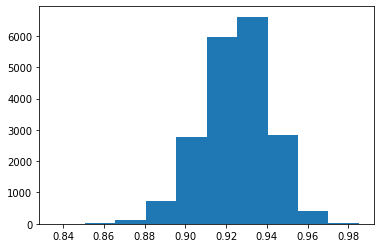

In [44]:
import matplotlib.pyplot as plt

plt.hist(df_tokenized_val_new['score'])
plt.show()

In [58]:
df_tokenized_val_new[:10000].to_csv("/content/drive/MyDrive/Summary_task/result_final.csv",mode = 'w')